In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import random
import os
import csv

from Config import Config
from Models import KeypointDetectionModel, ConfidenceModel

/Users/julienstal/Library/Python/3.9/lib/python/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
def split_data(data, test_size=0.2, random_seed=None):
    """
    Split dataset into train and test datasets. In our case, datasets are lists of dictionaries which
    contain entries: "Image Name", "x1", "y1", "x2", "y2"
    
    Parameters:
        data (list of dict): The input data to be split.
        test_size (float): Proportion of the dataset to include in the test split (default is 0.2).
        random_seed (int, optional): Random seed for reproducibility (default is None).
    
    Returns:
        tuple: (train_data, test_data) where both are lists of dictionaries.
    """
    if random_seed is not None:
        random.seed(random_seed)
    
    # Shuffle the data
    shuffled_data = data[:]
    random.shuffle(shuffled_data)
    
    # Compute the split index
    split_idx = int(len(shuffled_data) * (1 - test_size))
    
    # Split the data
    train_data = shuffled_data[:split_idx]
    test_data = shuffled_data[split_idx:]
    
    return train_data, test_data

In [4]:
"""
Create datasets by reading the csv files that contain the coordinates.
"""
with open(Config.coords_file_path, mode='r') as file:
    reader = csv.DictReader(file)  # Use DictReader to automatically map rows to dictionaries
    data = [row for row in reader]  # Convert each row into a dictionary and store in a list

train_data, test_data = split_data(data)
print(f"{len(train_data)} training points and {len(test_data)} test points.")

1919 training points and 480 test points.


In [5]:
# Use "mps" to use GPU on macs ("cuda" on non-mac). "cpu" is slower. 
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Training on device: {device}")

Training on device: mps


In [6]:
"""
Create and train keypoint detection model. 
The KeypointDetection Model (KPD) takes images as inputs and learns to find the two points defining Weber's length.
Note: we keep track and restore the best performing version on the test dataset to avoid overfitting
"""
kpd_model = KeypointDetectionModel.KeypointDetectionModel().to(device)
KeypointDetectionModel.train_kpd_model(kpd_model, train_data, test_data, 50, 100, 301)

Epoch 0: test loss = 0.13449616730213165, lr = 9.900000000000001e-05
Epoch 50: test loss = 0.004255479667335749, lr = 5.9895600646616125e-05
Epoch 100: test loss = 0.003707545343786478, lr = 3.62372017860497e-05
Epoch 150: test loss = 0.003253836650401354, lr = 2.1923726936647233e-05
Epoch 200: test loss = 0.0024561514146625996, lr = 1.326398781093821e-05
Epoch 250: test loss = 0.0022509347181767225, lr = 8.024793100055947e-06
Epoch 300: test loss = 0.002703562378883362, lr = 4.855048513057286e-06


In [75]:
"""
Create and train the confidence model (same mechanism as above to avoid overfitting).
The confidence model takes images as inputs and outputs a number estimating the error of the KPD model on the given image.
It learns to estimate how hard an image is for the KPD model (for example unusual body shape, too many legs leading to hidden KeyPoint, ...).
The goal is to be able to predict for which images the KPD model can be trusted.
"""
kpd_model.eval()

conf_model = ConfidenceModel.ConfidenceModel().to(device)
# Warning: Some fixes needed, training is useless when using error normalization (would be desirable).
# Also, training is super unpredictable, loss fluctuates and doesn't descend much, is super sen
ConfidenceModel.train_conf_model(conf_model, kpd_model, train_data, test_data, 100, 400, 61, feedback_rate=10, normalize_errors=False, initial_lr=1e-6, lr_decay=0.97)

Epoch 0: test loss = 0.0031898850575089455, lr = 9.7e-07
Epoch 10: test loss = 0.000541016343049705, lr = 7.153014030880803e-07
Epoch 20: test loss = 4.845174771617167e-05, lr = 5.274805126389445e-07
Epoch 30: test loss = 1.0265011951560155e-05, lr = 3.8897685648686274e-07
Epoch 40: test loss = 2.1662692233803682e-05, lr = 2.868409187771585e-07
Epoch 50: test loss = 1.8998873201780953e-05, lr = 2.1152341408698504e-07
Epoch 60: test loss = 1.621848605282139e-05, lr = 1.5598246895092924e-07


Let's take a look at the predictions the model believes in

Confident predictions:
Error estimation =  0.0001791343092918396


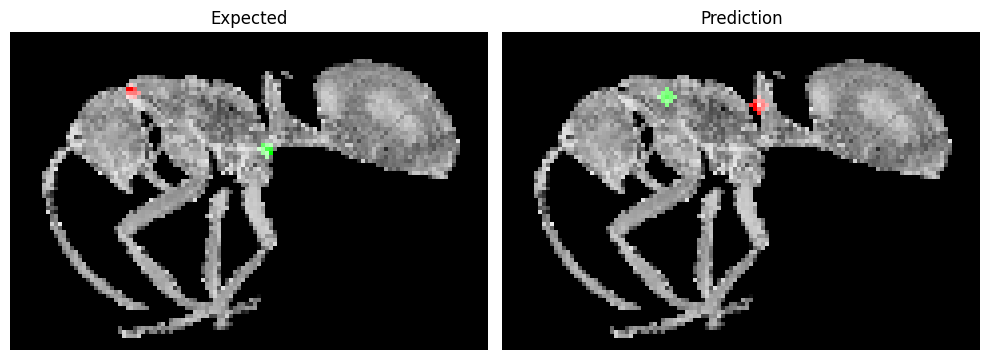

Error estimation =  0.0005602836608886719


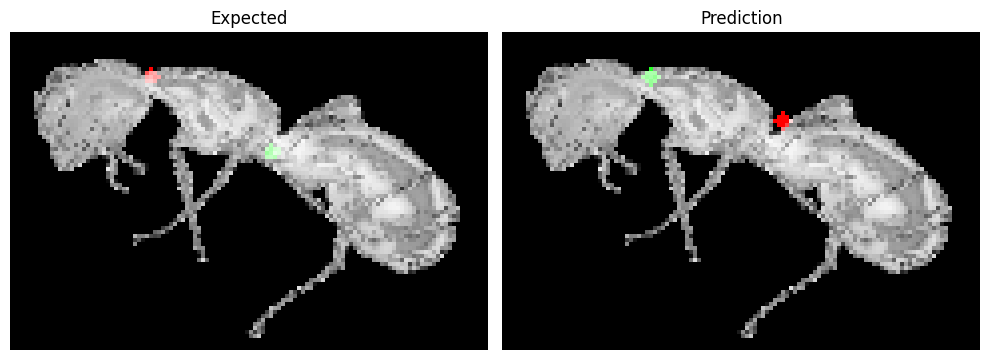

Error estimation =  0.0002511441707611084


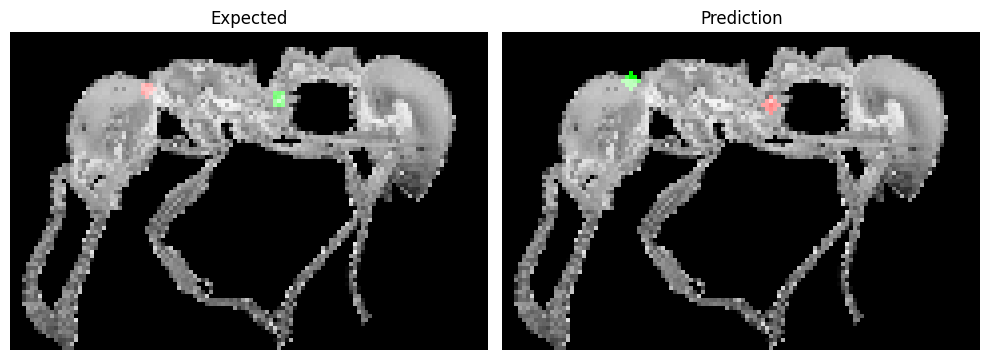

Error estimation =  0.0008597895503044128


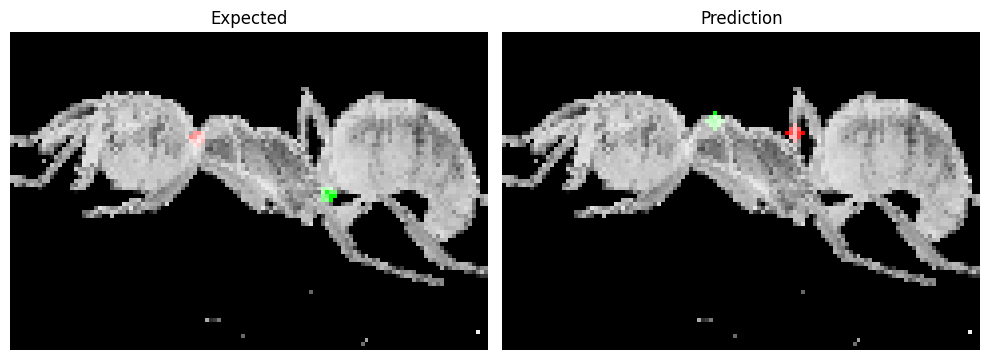

Error estimation =  0.0004962533712387085


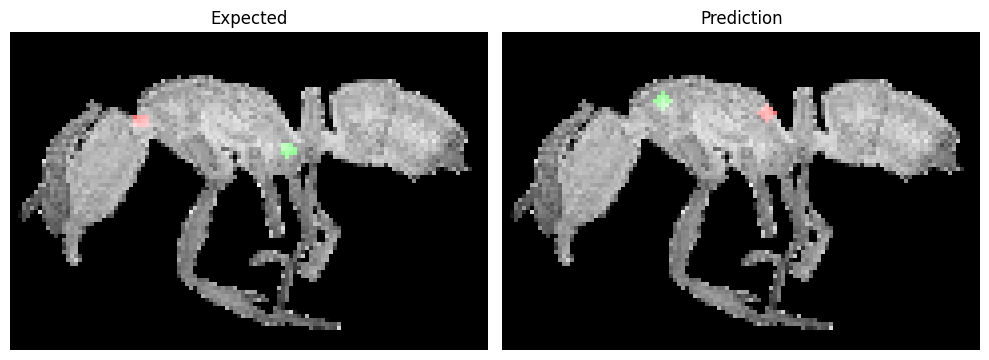

Error estimation =  0.0009418502449989319


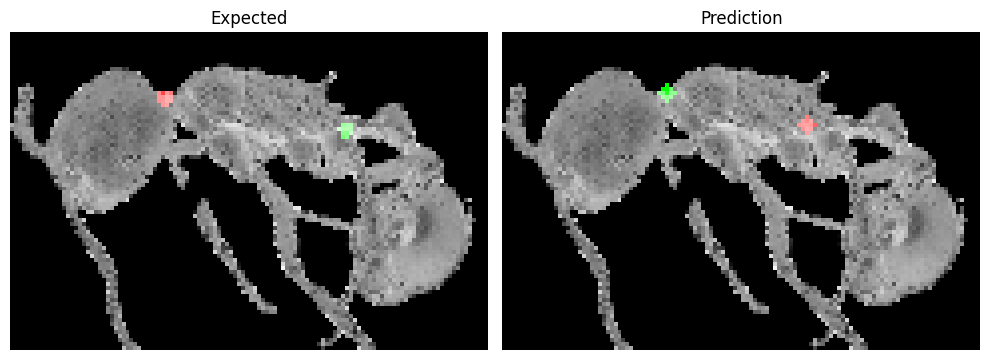

Error estimation =  0.0007206350564956665


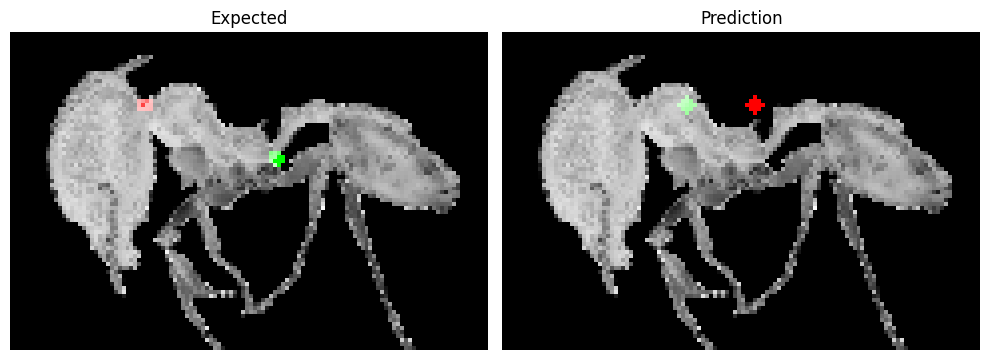

In [81]:
kpd_model.eval()
conf_model.eval()

print("Confident predictions:")
KeypointDetectionModel.plot_model_prediction(kpd_model, test_data, 40, conf_model = conf_model, error_estimation_interval= [0, 0.001],augment_images=False, device="mps")

And let's take a look at the predictions the model doesn't trust. The model has learned that some patterns in the following images make it hard for the keypoint detection model to be accurate.

Non-confident predictions:
Error estimation =  0.004906564950942993


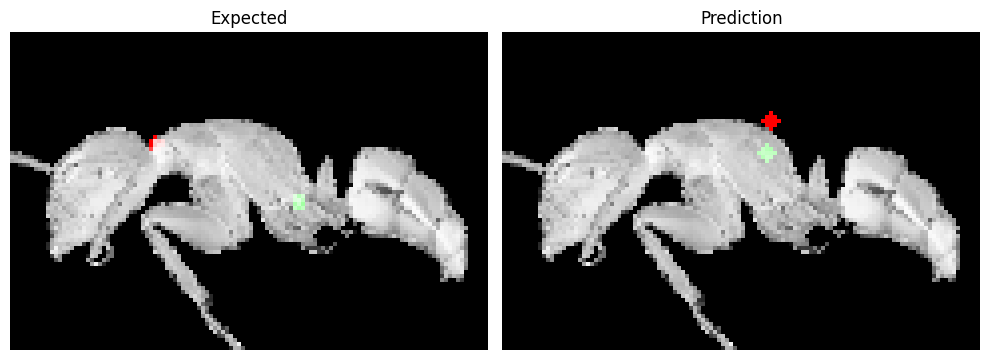

Error estimation =  0.007620140910148621


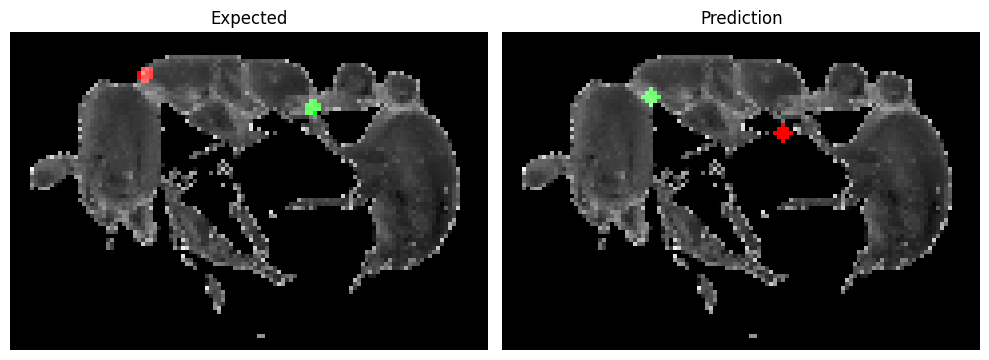

Error estimation =  0.004184752702713013


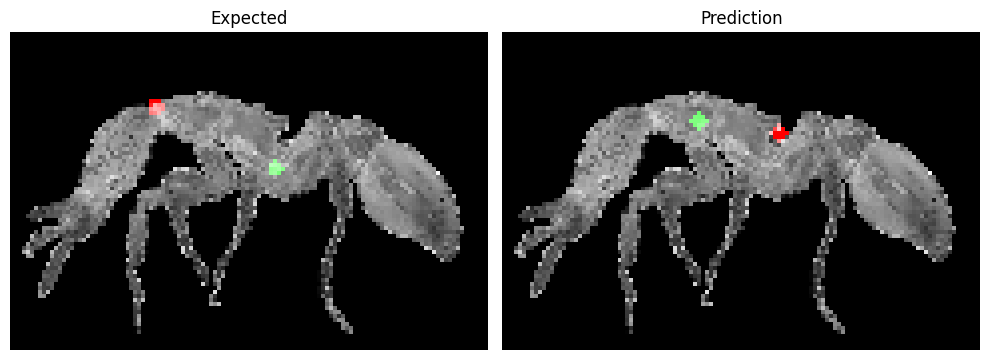

Error estimation =  0.00461047887802124


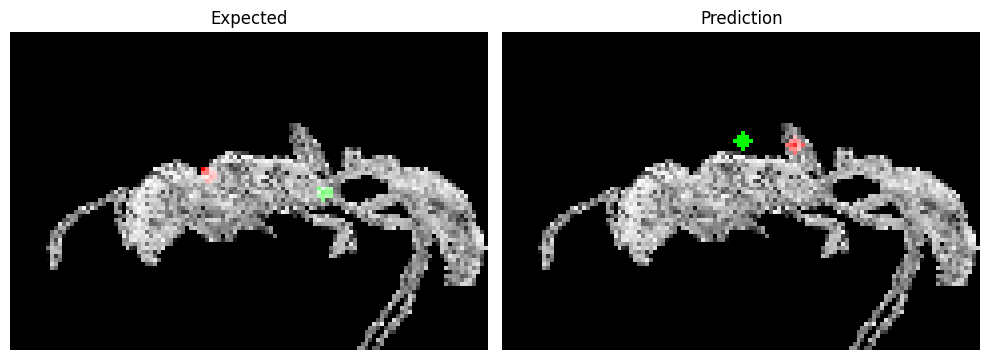

Error estimation =  0.005651414394378662


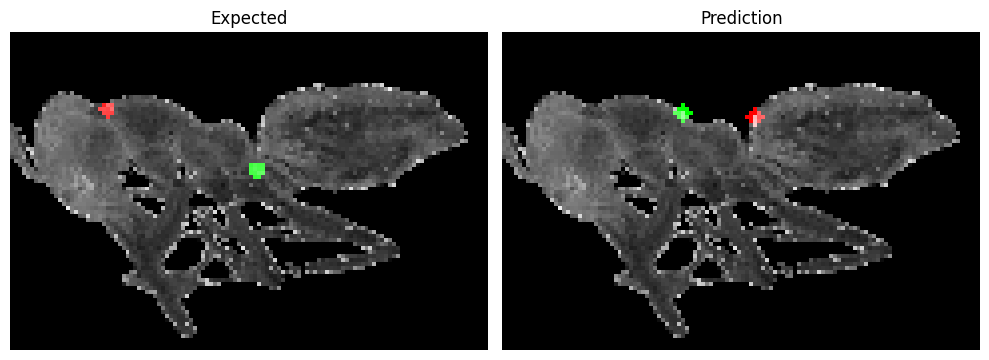

In [91]:
print("Non-confident predictions:")
KeypointDetectionModel.plot_model_prediction(kpd_model, test_data, 50, conf_model = conf_model, error_estimation_interval= [0.004, 1],augment_images=False, device="mps")